In [2]:
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import joblib
import os

In [3]:
#  2. Load the dataset

DATA_PATH = "insurance.csv"  # update path if needed
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Summary Statistics:


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


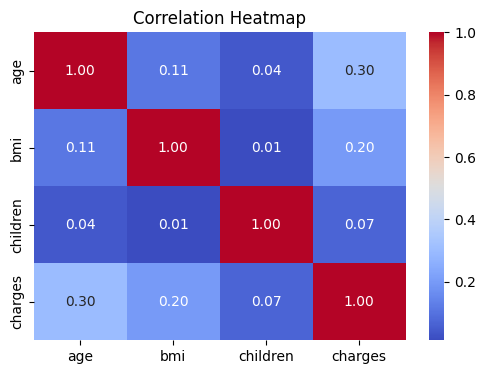

In [4]:
# 3. Quick EDA (Exploratory Data Analysis)
print("\nDataset Info:\n")
print(df.info())

print("\nMissing values per column:\n", df.isnull().sum())

print("\nSummary Statistics:")
display(df.describe(include='all'))

# Correlation heatmap (numerical features)
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [5]:
# 4. Create Binary Target Variable
# Label = 1 if charge > median (High), else 0 (Low)
median_charge = df["charges"].median()
df["high_charge"] = (df["charges"] > median_charge).astype(int)

print(f"Median charge: {median_charge:.2f}")
print(df["high_charge"].value_counts(normalize=True))

# Drop target leakage column 'charges'
X = df.drop(columns=["charges", "high_charge"])
y = df["high_charge"]

Median charge: 9382.03
high_charge
1    0.5
0    0.5
Name: proportion, dtype: float64


In [6]:
# 5. Split the data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1070, 6)
Test shape: (268, 6)


In [7]:
#  6. Data Preprocessing (Scaling + Encoding)

numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [8]:
#  7. Build Classification Models
models = {
    "Logistic Regression": Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", LogisticRegression(max_iter=1000))]
    ),
    "Random Forest": Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))]
    ),
    "Gradient Boosting": Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", HistGradientBoostingClassifier(random_state=42))]
    )
}

In [9]:
# 🧠 8. Train and Evaluate Models

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1] if hasattr(model.named_steps["classifier"], "predict_proba") else preds
    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, probs)
    results[name] = {"Accuracy": acc, "ROC-AUC": roc}
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | ROC-AUC: {roc:.4f}")
    print(classification_report(y_test, preds))


=== Logistic Regression ===
Accuracy: 0.8993 | ROC-AUC: 0.9425
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       134
           1       0.88      0.92      0.90       134

    accuracy                           0.90       268
   macro avg       0.90      0.90      0.90       268
weighted avg       0.90      0.90      0.90       268


=== Random Forest ===
Accuracy: 0.9403 | ROC-AUC: 0.9490
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       134
           1       0.98      0.90      0.94       134

    accuracy                           0.94       268
   macro avg       0.94      0.94      0.94       268
weighted avg       0.94      0.94      0.94       268


=== Gradient Boosting ===
Accuracy: 0.9366 | ROC-AUC: 0.9464
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       134
           1       0.98      0.90      0.93       134

In [10]:
# Compare model performance
results_df = pd.DataFrame(results).T.sort_values("ROC-AUC", ascending=False)
display(results_df)

,Accuracy,ROC-AUC
Random Forest,0.940299,0.949042
Gradient Boosting,0.936567,0.946369
Logistic Regression,0.899254,0.942526


In [11]:
# 🔧 9. Hyperparameter Tuning (Random Forest)
rf_pipeline = models["Random Forest"]

param_dist = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 6, 10, 15],
    "classifier__min_samples_split": [2, 5, 10],
}

rf_search = RandomizedSearchCV(
    rf_pipeline, param_distributions=param_dist,
    n_iter=8, scoring="roc_auc", cv=3,
    random_state=42, n_jobs=-1
)

print("\n🔍 Running RandomizedSearchCV for Random Forest...")
rf_search.fit(X_train, y_train)
print("Best Params:", rf_search.best_params_)

# Evaluate best model
best_rf = rf_search.best_estimator_
best_preds = best_rf.predict(X_test)
best_probs = best_rf.predict_proba(X_test)[:, 1]
print("\nTuned Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, best_preds))
print("ROC-AUC:", roc_auc_score(y_test, best_probs))
print(classification_report(y_test, best_preds))


🔍 Running RandomizedSearchCV for Random Forest...
Best Params: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__max_depth': 15}

Tuned Random Forest Results:
Accuracy: 0.9440298507462687
ROC-AUC: 0.9530519046558253
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       134
           1       0.98      0.91      0.94       134

    accuracy                           0.94       268
   macro avg       0.95      0.94      0.94       268
weighted avg       0.95      0.94      0.94       268



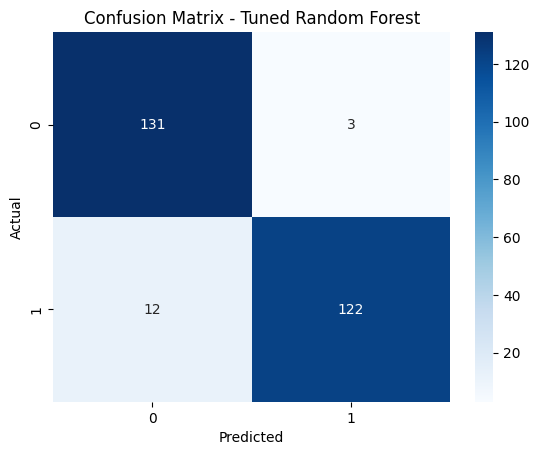

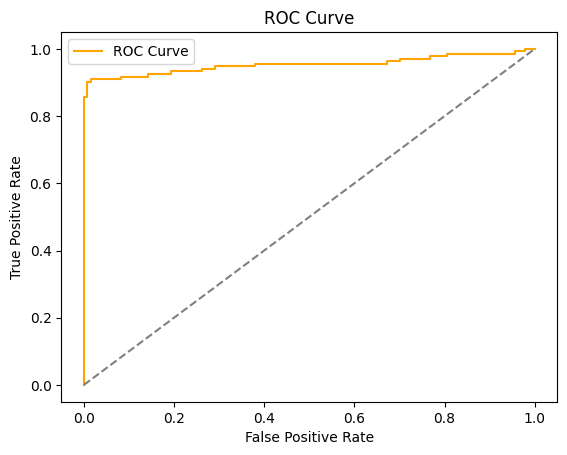

In [12]:
#  10. Confusion Matrix & ROC Curve
cm = confusion_matrix(y_test, best_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_probs)
plt.plot(fpr, tpr, color='orange', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

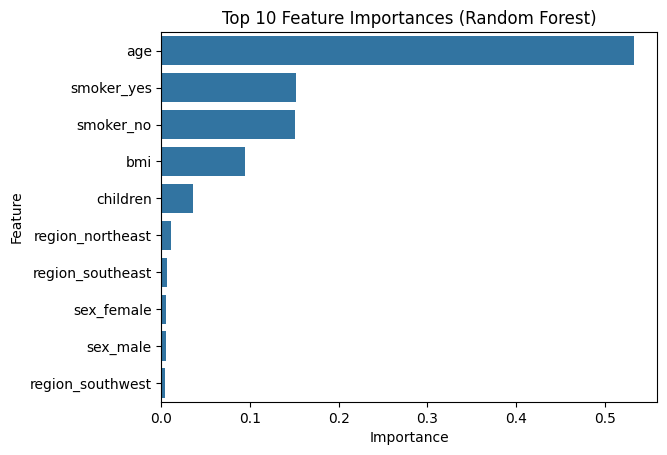

In [14]:
#  11. Feature Importance (from RF)

final_rf = best_rf.named_steps["classifier"]
ohe = best_rf.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
feature_names = numeric_features + list(ohe.get_feature_names_out(categorical_features))
importances = final_rf.feature_importances_

feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

In [15]:
#  12. Save Final Model

os.makedirs("/mnt/data/models", exist_ok=True)
model_path = "/mnt/data/models/final_rf_classifier.joblib"
joblib.dump(best_rf, model_path)
print(f"\n✅ Final tuned Random Forest model saved to: {model_path}")


✅ Final tuned Random Forest model saved to: /mnt/data/models/final_rf_classifier.joblib
